# Photos of yeast growth for Y2H

- [X] Get the well info
- [X] Make yeast pictures
- [X] Make a matrix showing growth score
- [X] Make a matrix showing final calls

In [5]:
import os

import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import pandas as pd
import tqdm

import ccsblib
from ccsblib import ccsbplotlib as cplt
from crop_y2h_images import yeast_spot_grid

from plotting import y2h_ppi_per_tf_gene_plot, isoform_display_name
from data_loading import load_isoform_and_paralog_y2h_data

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', 50)

In [6]:
y2h = load_isoform_and_paralog_y2h_data()
y2h = y2h.sort_values(['ad_gene_symbol', 'ad_clone_acc', 'db_gene_symbol'])
qry = """SELECT *
           FROM tf_screen.tf_isoform_final
          WHERE category = 'ppi';"""
df = pd.read_sql(qry, ccsblib.paros_connection()).drop(columns=['category'])
y2h = pd.merge(y2h, 
               df,
               how='left', 
               on=['ad_orf_id', 'db_orf_id'])
y2h.head()

,category,ad_orf_id,ad_clone_acc,ad_gene_symbol,db_orf_id,db_gene_symbol,score,standard_batch,retest_pla,retest_pos,in_orfeome_screen,in_focussed_screen,in_hi_union,in_lit_bm,is_partner_category_DNA_polymerase,is_partner_category_DNA_repair,is_partner_category_DNA_replication,is_partner_category_RNA_processing,is_partner_category_RNA_turnover,is_partner_category_TF,is_partner_category_cell_cycle,is_partner_category_cell-cell_signaling,is_partner_category_cofactor,is_partner_category_cytoskeleton,is_partner_category_membrane_protein,...,is_partner_category_translation,is_partner_category_vesicle_transport,is_cofactor_subtype_both,is_cofactor_subtype_coactivator,is_cofactor_subtype_corepressor,is_cofactor_subtype_unknown,ad_symbol,3at_repeat_1_score,3at_repeat_2_score,3at_repeat_3_score,chx_repeat_1_score,chx_repeat_2_score,chx_repeat_3_score,lw_repeat_1_score,lw_repeat_2_score,lw_repeat_3_score,avg_at,avg_cx,avg_lw,growth_score,seq1,seq2,final_seq,final_score,retest_id
0,non_paralog_control,100093,ARNT2|1/6|08C12,ARNT2,53886,AES,1,TFr08,94,F07,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tf_paralog_ppis,100093,ARNT2|1/6|08C12,ARNT2,11222,ARNTL,0,TFr08,61,G10,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tf_paralog_ppis,100093,ARNT2|1/6|08C12,ARNT2,56620,ARNTL2,0,TFr08,105,E08,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,non_paralog_control,100093,ARNT2|1/6|08C12,ARNT2,6534,BANP,NS,TFr08,6,B03,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,tf_paralog_ppis,100093,ARNT2|1/6|08C12,ARNT2,54316,CLOCK,1,TFr08,43,H04,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


array([0.        , 0.66666667, 0.16666667, 1.        , 0.33333333,
       0.5       , 1.33333333, 2.33333333, 0.83333333, 1.5       ,
       2.5       , 1.16666667, 1.83333333, 2.        ,        nan,
       1.66666667, 2.83333333, 3.        , 2.66666667, 0.75      ,
       3.33333333, 3.83333333, 4.        , 0.25      , 2.16666667,
       3.66666667, 3.16666667])

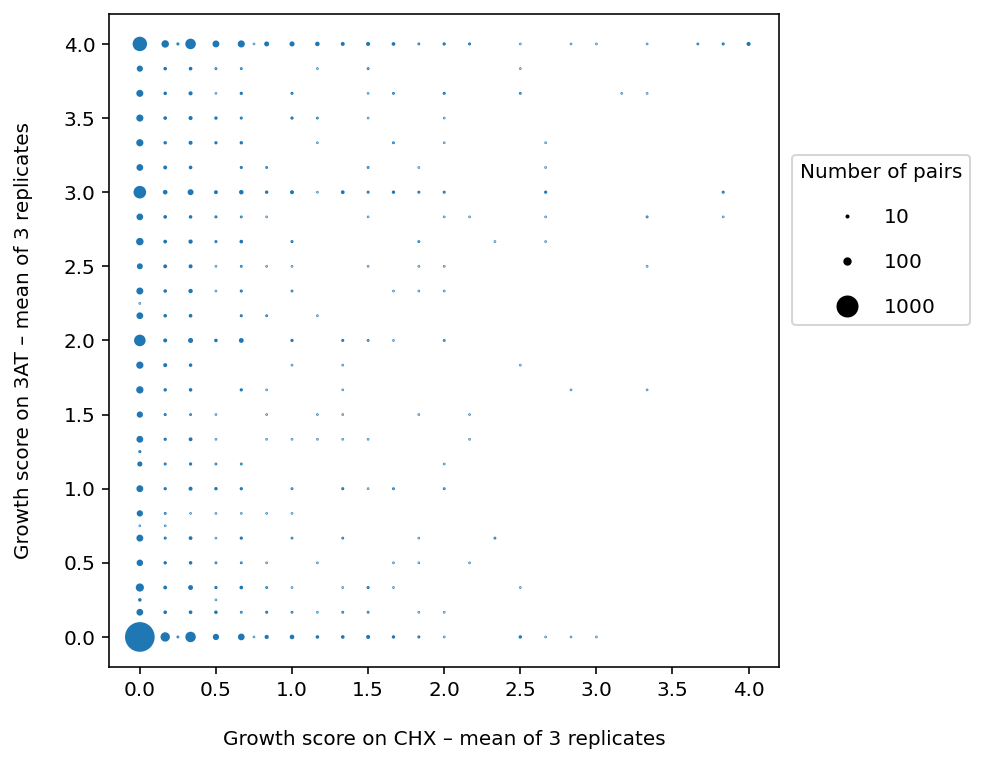

In [19]:
y2h.loc[y2h['category'] == 'tf_isoform_ppis', ['avg_cx', 'avg_at']]

cx_vals = y2h.loc[(y2h['category'] == 'tf_isoform_ppis') & y2h['avg_cx'].notnull(), 'avg_cx'].unique()
at_vals = y2h.loc[(y2h['category'] == 'tf_isoform_ppis') & y2h['avg_at'].notnull(), 'avg_at'].unique()

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 6)
scaling = 0.1
sc = ax.scatter(x=[x for x in cx_vals for y in at_vals],
           y=[y for x in cx_vals for y in at_vals],
           s=[((y2h['category'] == 'tf_isoform_ppis') &
               (y2h['avg_cx'] == x) & (y2h['avg_at'] == y)).sum() * scaling for x in cx_vals for y in at_vals],
           clip_on=False)
#ax.yaxis.set_tick_params(length=0)
#ax.xaxis.set_tick_params(length=0, rotation=90)
#for s in ax.spines.values():
#    s.set_visible(False)
#ax.set_xlim(-0.5, len(fams) - 0.5)
#ax.set_ylim(len(fams) - 0.5, -0.5)
ax.set_xlabel('Growth score on CHX – mean of 3 replicates',
              labelpad=15)
ax.set_ylabel('Growth score on 3AT – mean of 3 replicates',
              labelpad=15)
ax.legend(*sc.legend_elements('sizes',
                              num=[10, 100, 1000],
                              func=lambda x: x / scaling),
          bbox_to_anchor=[1.3, 0.8],
          title='Number of pairs',
         labelspacing=1.3)
plt.savefig('../../figures/growth_score_distribution.pdf', bbox_inches='tight')

In [86]:
from matplotlib import patches

def growth_score_grid(df, ax=None, fontsize=12):
    if ax is None:
        ax = plt.gca()
    rows = df['ad_clone_acc'].unique()
    columns = df['db_gene_symbol'].unique()
    for i_row, row in enumerate(rows):
        for i_column, column in enumerate(columns):
            if df.loc[(df['ad_clone_acc'] == row) & (df['db_gene_symbol'] == column), 'score'].values[0] == 'NS':
                rect = patches.Rectangle((i_column / len(columns), i_row / len(rows)),
                                         1 / len(columns),
                                         1 / len(rows),
                                         linewidth=3,
                                         edgecolor='r',
                                         facecolor='none')
                ax.add_patch(rect)
            for i_media, media in enumerate(['lw', 'chx', '3at']):
                for i_rep, rep in enumerate(['1', '2', '3']):
                    gs = df.loc[(df['ad_clone_acc'] == row) &
                                (df['db_gene_symbol'] == column),
                                media + '_repeat_' + rep + '_score'].values[0]
                    ax.text(i_column / len(columns) + (i_rep + 1) / (5 * len(columns)),
                            i_row / len(rows) + (i_media + 1) / (5 * len(rows)),
                            str('{:.2g}'.format(gs)),
                            ha='center',
                            va='center',
                            fontsize=fontsize)
    ax.invert_yaxis()
    ax.axis('off')


def per_tf_y2h_yeast_images(tf_gene):
    selections={    'ad_clone_acc': y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                                       (y2h['ad_gene_symbol'] == tf_gene),
                                       'ad_clone_acc'].unique(),
                    'db_gene_symbol': y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                                       (y2h['ad_gene_symbol'] == tf_gene),
                                       'db_gene_symbol'].unique(),
                    'media': ['LW', 'CX', 'AT'],
                    'rep': ['A', 'B', 'C']} 
    labels={'media': ['-LW', 'CHX', '3AT'],  #['SC -LW', 'SC -LH +3AT +CHX', 'SC -LWH +3AT'],
            'rep': [],
            'ad_clone_acc': [isoform_display_name(clone_acc) for clone_acc in selections['ad_clone_acc']]}
    n_column = len(selections['db_gene_symbol'])
    n_row = len(selections['ad_clone_acc'])
    if n_row < n_column:
        fig, axes = plt.subplots(3, 1)
        fig.set_size_inches((n_column + 1.2) * 0.5, (n_row * 3 + 1.5) * 0.5)
    else:
        fig, axes = plt.subplots(1, 3)
        fig.set_size_inches((n_column * 3 + 1.2) * 0.5, (n_row + 1.5) * 0.5)
    yeast_spot_grid(data=y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                                 (y2h['ad_gene_symbol'] == tf_gene), :],
                     variables=selections,
                     file_structure='{standard_batch}.{media}.rep{rep}',
                     well_img_dir='/Users/lukelambourne/Work/y2h_cropped_images/individual_cropped_images',
                     labels=labels,
                     ax=axes[0])
    growth_score_grid(y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                     (y2h['ad_gene_symbol'] == tf_gene), :],
                      ax=axes[1],
                      fontsize=6)
    axes[1].set_aspect(max(axes[0].get_ylim()) / max(axes[0].get_xlim()))    
    y2h_ppi_per_tf_gene_plot(tf_gene,
                             data=y2h,
                             ax=axes[2])
    if n_row < n_column:
        axes[2].set_xticks([])
        plt.subplots_adjust(hspace=0.2)
    else:
        axes[2].set_yticks([])
        plt.subplots_adjust(wspace=0.2)
    
    fig_dir = '../../figures/y2h_yeast_images'
    os.makedirs(fig_dir, exist_ok=True)
    plt.savefig(os.path.join(fig_dir, tf_gene + '_y2h_yeast_images_and_results.pdf'),
                bbox_inches='tight',
                dpi=600)
    plt.close(fig)

#per_tf_y2h_yeast_images('CREBZF')

In [87]:
for tf_gene in tqdm.tqdm(y2h.loc[(y2h['category'] == 'tf_isoform_ppis'), 'ad_gene_symbol'].unique()):
    per_tf_y2h_yeast_images(tf_gene)



  0%|          | 0/164 [00:00<?, ?it/s]

  1%|          | 1/164 [00:11<30:58, 11.40s/it]

  1%|          | 2/164 [00:12<22:29,  8.33s/it]

  2%|▏         | 3/164 [00:14<17:15,  6.43s/it]

  2%|▏         | 4/164 [00:18<15:32,  5.83s/it]

  3%|▎         | 5/164 [00:19<11:21,  4.29s/it]

  4%|▎         | 6/164 [00:24<11:22,  4.32s/it]

  4%|▍         | 7/164 [00:29<11:53,  4.54s/it]

  5%|▍         | 8/164 [00:30<09:25,  3.63s/it]

  5%|▌         | 9/164 [00:31<07:16,  2.82s/it]

  6%|▌         | 10/164 [00:34<07:04,  2.76s/it]

  7%|▋         | 11/164 [00:41<10:13,  4.01s/it]

  7%|▋         | 12/164 [00:42<08:19,  3.29s/it]

  8%|▊         | 13/164 [00:44<07:03,  2.80s/it]

  9%|▊         | 14/164 [00:49<08:26,  3.38s/it]

  9%|▉         | 15/164 [00:50<06:54,  2.78s/it]

 10%|▉         | 16/164 [00:51<05:20,  2.16s/it]

 10%|█         | 17/164 [00:52<04:43,  1.93s/it]

 11%|█         | 18/164 [00:59<08:23,  3.45s/it]

 12%|█▏        | 19/164 [01:04<09:18,  3.85s/it]

 12%|█▏        |

In [29]:
y2h.loc[y2h['ad_clone_acc'].str.startswith('ARNT2|2') &
        (y2h['db_gene_symbol'] == 'PID1'), :]

,category,ad_orf_id,ad_clone_acc,ad_gene_symbol,db_orf_id,db_gene_symbol,score,standard_batch,retest_pla,retest_pos,is_partner_category_DNA_polymerase,is_partner_category_DNA_repair,is_partner_category_DNA_replication,is_partner_category_RNA_editing,is_partner_category_RNA_processing,is_partner_category_RNA_turnover,is_partner_category_TF,is_partner_category_cell_cycle,is_partner_category_cell-cell_signaling,is_partner_category_cofactor,is_partner_category_cytoskeleton,is_partner_category_membrane_protein,is_partner_category_metabolism,is_partner_category_nuclear_transport,is_partner_category_other,is_partner_category_protein_folding,is_partner_category_protein_traffiking,is_partner_category_protein_turnover,is_partner_category_signaling,is_partner_category_translation,is_partner_category_vesicle_transport
1131,tf_isoform_ppis,101247,ARNT2|2/6|09E01,ARNT2,11285,PID1,1,TFr07,13,A03,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False


In [26]:
# CREB5-2 KRTAP10-8
y2h.loc[y2h['ad_clone_acc'].str.startswith('CREB5|2') &
        (y2h['db_gene_symbol'] == 'KRTAP10-8'), :]

,category,ad_orf_id,ad_clone_acc,ad_gene_symbol,db_orf_id,db_gene_symbol,score,standard_batch,retest_pla,retest_pos,...,is_partner_category_membrane_protein,is_partner_category_metabolism,is_partner_category_nuclear_transport,is_partner_category_other,is_partner_category_protein_folding,is_partner_category_protein_traffiking,is_partner_category_protein_turnover,is_partner_category_signaling,is_partner_category_translation,is_partner_category_vesicle_transport
9662,tf_isoform_ppis,101244,CREB5|2/3|08A12,CREB5,56717,KRTAP10-8,0,TFr07,102,B02,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# ETV2